## Testing Image Compression Methods

When creating the COCO-peripheral dataset, how should we save mongrels? 

Considerations:
 - This dataset will be large, so any potential savings from image compression will improve usability. 
 - Lossless PNG images are likely overkill in image quality.
 - JPG/JPEG encoding can save space, but may introduce artifacts especially at higher compression rates. 
 - Original COCO images are stored in a lossy JPG format. 
 - Mongrelization may affect encoding scheme because mongrels do not follow typical natural scene statistics.
 
 
Explore this space a bit more to find the optimal.

In [1]:
import os
from os import listdir
from os.path import getsize, isfile, join
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [108]:
# coco_path = './coco_test/'
# coco_flist =[f for f in listdir(coco_path) if isfile(join(coco_path, f))]
# coco_flist = [join(coco_path,f) for f in coco_flist if '.jpg' in f]
# coco_flist

base_directory = './60_olap_sweep'
eccentricities = [0,50,100,150,200,250,300,450]
image_num_list =  [19,69,979,552,205,139]
image_number = 552

output_folder = './compression_test'

image_name = str(image_number).zfill(12)

#os.system(f'cp ./coco_test/{image_name}.jpg {base_directory}/{image_name}.jpg')

In [129]:
def readin_im_mongrel(image_name, base_directory, showims=False):

    #original image
    original_fname = f'./coco_test/{image_name}.jpg'
    print(original_fname)
    ori_img = cv2.imread(original_fname)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    
    #eccentricities
    e = 350
    #for e in eccentricities_list[1:]:
    mongrel_fname = f'{base_directory}/{image_name}_X{e}_YNaN_2022-08-12_uniform_60olap_{e}/mongrelized_{image_name}_uniform_60olap_{e}.png'
    mong = cv2.imread(mongrel_fname)
    mong = cv2.cvtColor(mong, cv2.COLOR_BGR2RGB)
    
    return(ori_img, mong)

ori, mong = readin_im_mongrel(image_name, base_directory, showims=True)

./coco_test/000000000552.jpg


In [130]:
#cv2 color conversion
ori_save = cv2.cvtColor(ori,cv2.COLOR_RGB2BGR)
mong_save = cv2.cvtColor(mong,cv2.COLOR_RGB2BGR)

#paths
#original
fname_ori = f'./coco_test/{image_name}.jpg'
#jpg
jpg_fname_ori = os.path.join(output_folder, f'{image_name}_ori.jpg')
jpg_fname_mong = os.path.join(output_folder, f'{image_name}_mong.jpg')
#png
png_fname_ori = os.path.join(output_folder, f'{image_name}_ori.png')
png_fname_mong = os.path.join(output_folder, f'{image_name}_mong.png')

#save
#png
cv2.imwrite(png_fname_ori,ori_save)
cv2.imwrite(png_fname_mong,mong_save)
#jpg_default
cv2.imwrite(jpg_fname_ori,ori_save)
cv2.imwrite(jpg_fname_mong,mong_save)


#check file size
print('Orig coco (jpg code) size:', getsize(fname_ori))

print('Orig png compression size:', getsize(png_fname_ori))
print('Mong png compression size:', getsize(png_fname_mong))

print('Orig jpg compression size:', getsize(jpg_fname_ori))
print('Mong jpg compression size:', getsize(jpg_fname_mong))



Orig coco (jpg code) size: 152003
Orig png compression size: 659219
Mong png compression size: 531536
Orig jpg compression size: 177852
Mong jpg compression size: 125532


Mongrels seem to actually compress slightly better than natural images do in .jpg encoding. This is interesting and somewhat surprising!

## Test Differences between png encoded and jpg

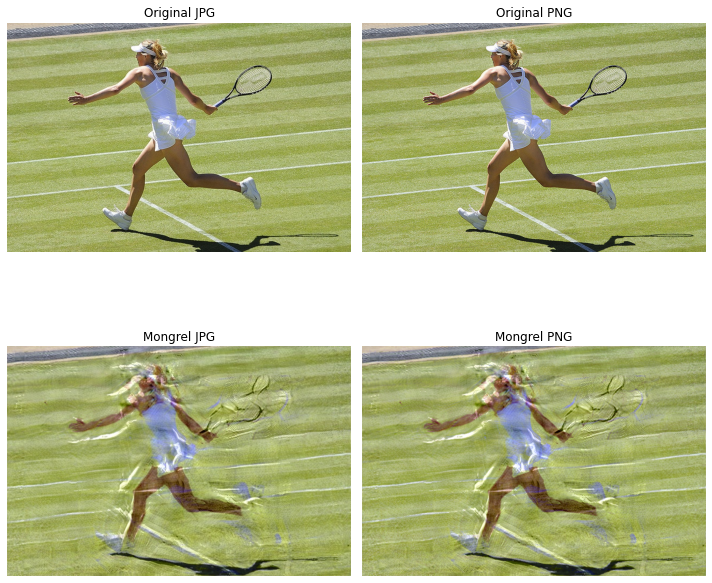

In [131]:
ori_jpg = cv2.cvtColor(cv2.imread(jpg_fname_ori),cv2.COLOR_BGR2RGB)
ori_png = cv2.cvtColor(cv2.imread(png_fname_ori),cv2.COLOR_BGR2RGB)
mong_jpg = cv2.cvtColor(cv2.imread(jpg_fname_mong),cv2.COLOR_BGR2RGB)
mong_png = cv2.cvtColor(cv2.imread(png_fname_mong),cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(ori_jpg)
plt.axis('off')
plt.title('Original JPG')
plt.subplot(2,2,2)
plt.imshow(ori_png)
plt.axis('off')
plt.title('Original PNG')
plt.subplot(2,2,3)
plt.imshow(mong_jpg)
plt.axis('off')
plt.title('Mongrel JPG')
plt.subplot(2,2,4)
plt.imshow(mong_png)
plt.axis('off')
plt.title('Mongrel PNG')
plt.tight_layout()
plt.show()

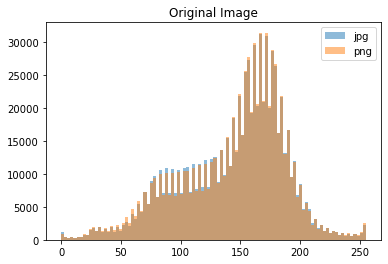

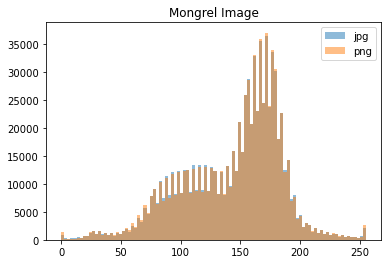

In [132]:
#Histograms

plt.hist(ori_jpg.flatten(),bins=100,label='jpg',alpha=0.5)
plt.hist(ori_png.flatten(),bins=100,label='png',alpha=0.5)
plt.legend()
plt.title('Original Image')
plt.show()

plt.hist(mong_jpg.flatten(),bins=100,label='jpg',alpha=0.5)
plt.hist(mong_png.flatten(),bins=100,label='png',alpha=0.5)
plt.legend()
plt.title('Mongrel Image')
plt.show()

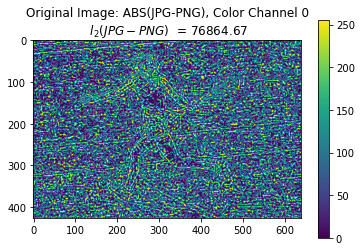

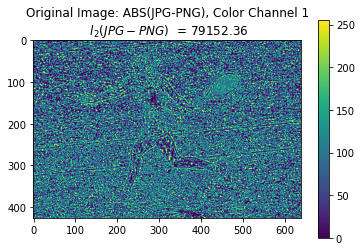

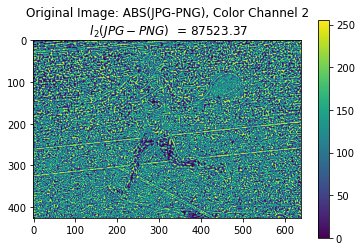

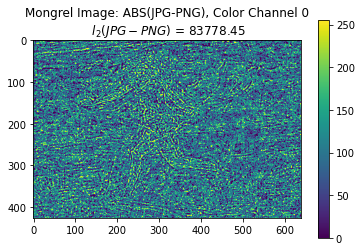

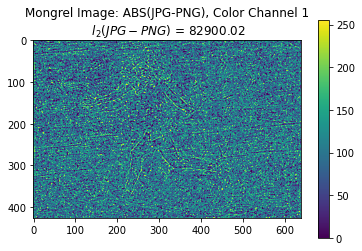

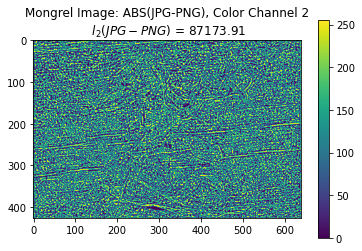

In [133]:
#BELOW DOES NOT SEEM CORRECT. DIFFERENCES ARE TOO BIG!!!

for c in range(3):
    l_ori = np.linalg.norm(ori_jpg[:,:,c] - ori_png[:,:,c])
    plt.imshow(np.abs(ori_jpg[:,:,c] - ori_png[:,:,c]))
    plt.colorbar()
    plt.title(f'Original Image: ABS(JPG-PNG), Color Channel {c}\n $l_2(JPG-PNG)$  = {np.round(l_ori,2)}')
    plt.show()
    
for c in range(3):
    l_mong = np.linalg.norm(mong_jpg[:,:,c] - mong_png[:,:,c])
    plt.imshow(np.abs(mong_jpg[:,:,c] - mong_png[:,:,c]))
    plt.colorbar()
    plt.title(f'Mongrel Image: ABS(JPG-PNG), Color Channel {c}\n $l_2(JPG-PNG)$ = {np.round(l_mong,2)}')
    plt.show()

### Test Compressed Mongrels with Detection Model

Detectron2 faster R-CNN (Resnet-50, learning schedule 3x)

In [134]:
import torch
# detectron2 must be installed
import detectron2
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [135]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file("/home/gridsan/aharrington/detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = "/home/gridsan/aharrington/model_final_280758.pkl"
cfg.MODEL.DEVICE = 'cpu'
predictor = DefaultPredictor(cfg)


/home/gridsan/aharrington/model_final_280758.pkl


In [136]:
im_names = ['Original JPG','Original PNG','Mongrel JPG','Mongrel PNG']
ims = [ori_jpg, ori_png, mong_jpg, mong_png]
outputs = []
for i in range(len(ims)):
    print(im_names[i])
    output = predictor(ims[i])
    outputs.append(output)
    # look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
    # print(output["instances"].pred_classes)
    class_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
    pred_class_names = list(map(lambda x: class_names[x], output["instances"].pred_classes))
    print(f'total instances: {len(pred_class_names)}')
    print(pred_class_names)
    print(output["instances"].scores)
    print

Original JPG
total instances: 2
['person', 'tennis racket']
tensor([0.9994, 0.9984])
Original PNG
total instances: 2
['person', 'tennis racket']
tensor([0.9995, 0.9985])
Mongrel JPG
total instances: 6
['person', 'person', 'surfboard', 'person', 'surfboard', 'person']
tensor([0.8747, 0.8507, 0.4690, 0.3436, 0.2898, 0.2546])
Mongrel PNG
total instances: 4
['person', 'person', 'surfboard', 'person']
tensor([0.7986, 0.6577, 0.5406, 0.2691])


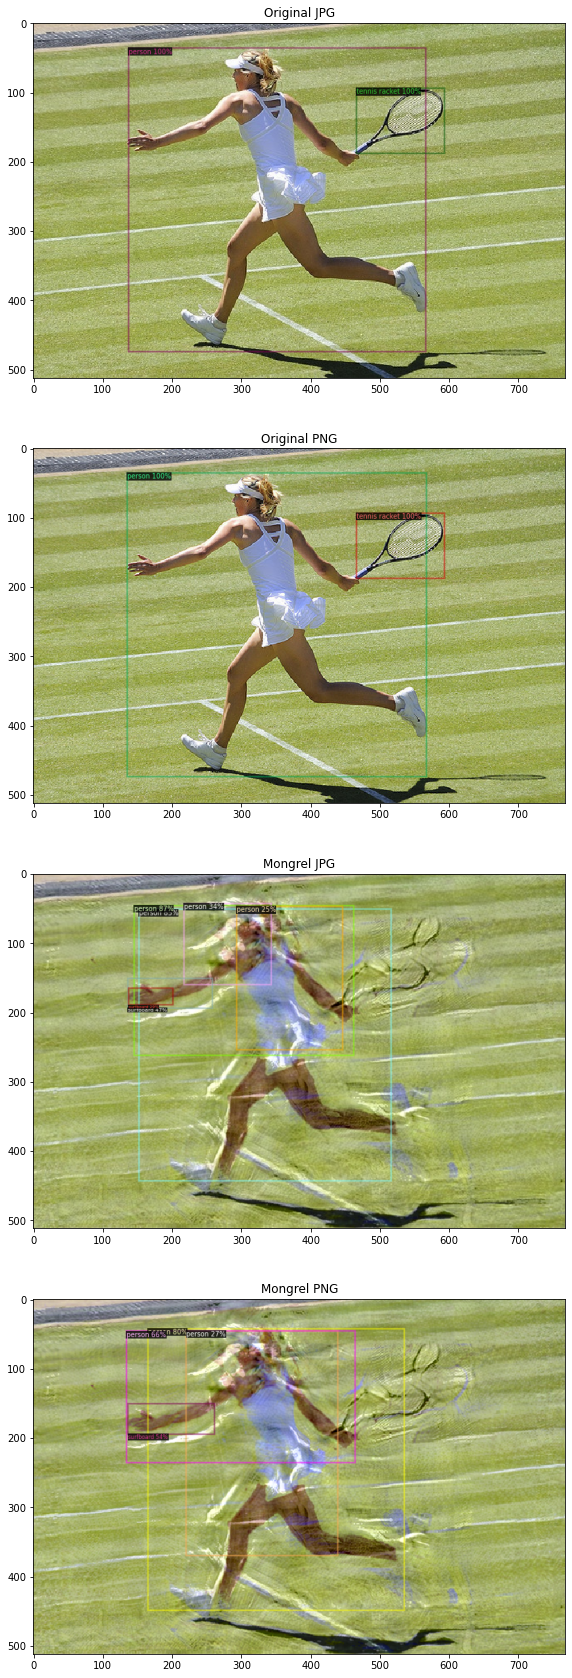

In [137]:
fig, axes = plt.subplots(4, figsize=(10,30))
for i in range(len(ims)):
    v = Visualizer(ims[i][:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs[i]["instances"].to("cpu"))
    axes[i].imshow(out.get_image()[:, :, ::-1])
    axes[i].set_title(im_names[i])
plt.show()

### Evluate DETR, YOLO